In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('city_temperature.csv', low_memory = False).drop(columns = ['State', 'Region', 'City'])

In [3]:
le = LabelEncoder()

In [4]:
df['Country'] = le.fit_transform(df['Country'])

In [5]:
df.head()

,Country,Month,Day,Year,AvgTemperature
0,1,1,1,1995,64.2
1,1,1,2,1995,49.4
2,1,1,3,1995,48.8
3,1,1,4,1995,46.4
4,1,1,5,1995,47.9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Country         int32  
 1   Month           int64  
 2   Day             int64  
 3   Year            int64  
 4   AvgTemperature  float64
dtypes: float64(1), int32(1), int64(3)
memory usage: 99.8 MB


In [7]:
df.describe()

,Country,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,8.625216e+01,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.795075e+01,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,5.500000e+01,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,1.140000e+02,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,1.140000e+02,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.240000e+02,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [8]:
# Treating -99 Temperature Value as NaN for Data Imputation
df.loc[df['AvgTemperature'] == -99, 'AvgTemperature'] = np.NAN
df.isnull().sum()

Country               0
Month                 0
Day                   0
Year                  0
AvgTemperature    79672
dtype: int64

In [9]:
df.notna().sum()

Country           2906327
Month             2906327
Day               2906327
Year              2906327
AvgTemperature    2826655
dtype: int64

In [10]:
df['Country'].value_counts()

114    1455337
18       74245
3        46330
20       46329
49       37063
        ...   
43        5065
52        4641
17        4543
37        4378
93        3427
Name: Country, Length: 125, dtype: int64

<AxesSubplot:>

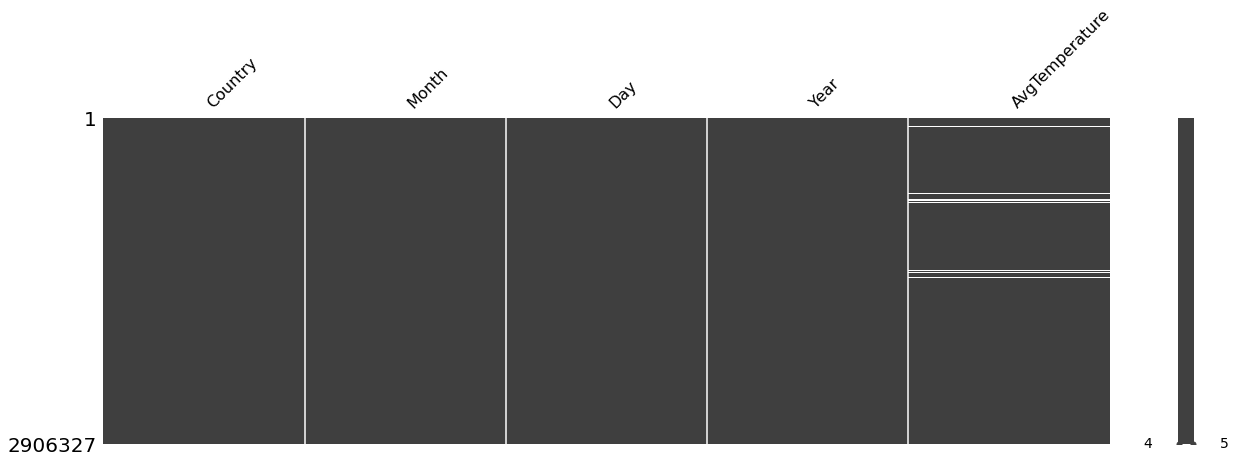

In [11]:
mno.matrix(df, figsize = (20, 6))

### Using Regression to impute missing data
When we have multiple variables with missing values, we can't just directly use Regression Imputation to impute one of them as the predictors contain missing data themselves. But then, how can we impute one variable without imputing another?

We can avoid this Catch-22 situation by initially imputing all the variables with missing values using some trivial methods like Simple Random Imputation (we impute the missing data with random observed values of the variable) which is later followed by Regression Imputation of each of the variables iteratively.

In [12]:
missing_columns = ['AvgTemperature']

In [13]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [14]:
for feature in missing_columns:
    df[feature + '_imp'] = df[feature]
    df = random_imputation(df, feature)

### Deterministic Regression Imputation
In Deterministic Regression Imputation, we replace the missing data with the values predicted in our regression model and repeat this process for each variable.

In [15]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = df[feature + "_imp"]
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    # Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    # Observe that the index of the missing data from the original dataframe is preserved
    deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

<AxesSubplot:>

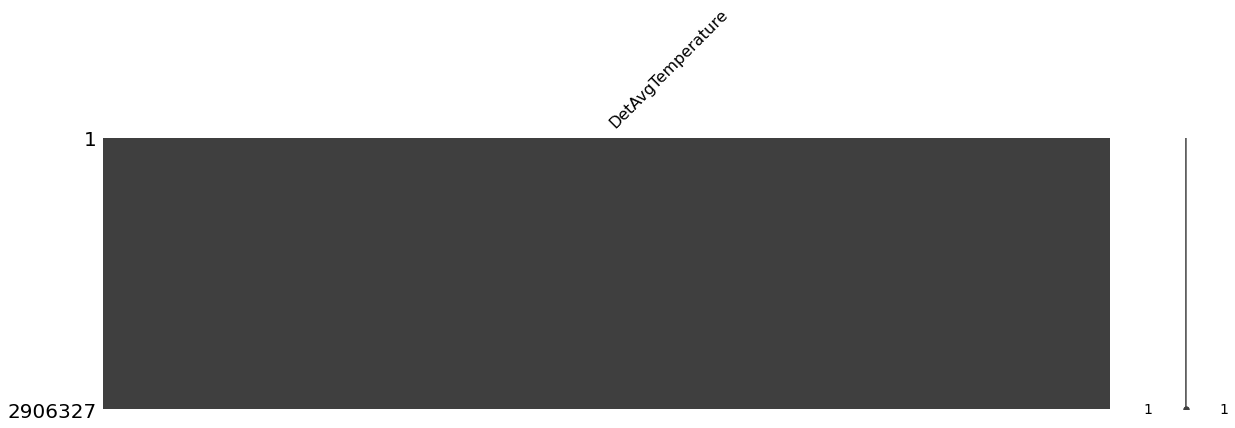

In [16]:
mno.matrix(deter_data, figsize = (20, 5))

A major disadvantage in this method is that we reduce the inherent variability in the imputed variable. In other words, since we substitute the missing data with regression outputs, the predicted values lie along the regression hyperplane where the variable would have actually contained some noise/bias.

We can visualize the above fact in a number of ways. First one is plotting histograms for both the incomplete data and the complete data in which we can observe that the plot of the completed data is taller and narrower when compared to that of the incomplete data. In other words, the complete data has a lesser standard deviation (thus lesser variability) than the incomplete data.

Another method would be plotting a boxplot in which we can observe that the IQ Range is pretty compressed for the complete data when compared to that in the incomplete data.

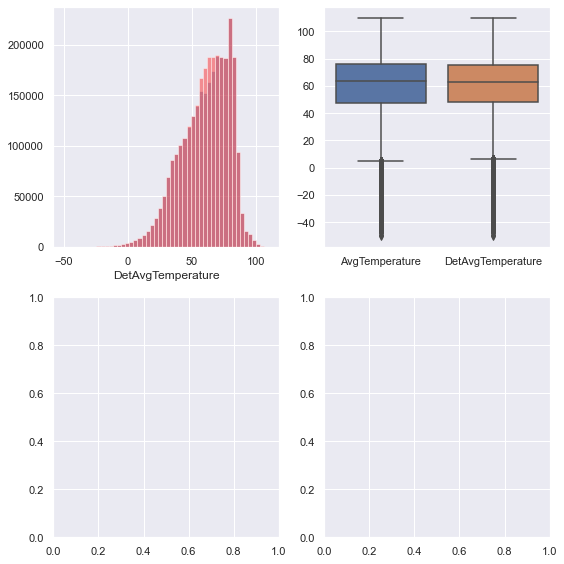

In [17]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["AvgTemperature"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')
    
    sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])
    
plt.tight_layout()

In [18]:
pd.concat([df[["AvgTemperature"]], deter_data[["DetAvgTemperature"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
AvgTemperature,2826655.0,60.373884,19.097440,-50.0,47.4,63.3,75.9,110.0
DetAvgTemperature,2906327.0,60.416086,18.843649,-50.0,47.9,63.1,75.5,110.0


### Stochastic Regression Imputation
To add uncertainty back to the imputed variable values, we can add some normally distributed noise with a mean of zero and the variance equal to the standard error of regression estimates . This method is called as Random Imputation or Stochastic Regression Imputation

In [19]:
random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
        
    random_data["Ran" + feature] = df[feature + '_imp']
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    # Standard Error of the regression estimates is equal to std() of the errors of each estimates
    predict = model.predict(df[parameters])
    std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()
    
    # Observe that the index of the missing data from the original dataframe is preserved
    random_predict = np.random.normal(size = df[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df[feature].isnull()) & 
                                                                            (random_predict > 0)]

When we introduce this Gaussian noise we may end up imputing some negative values for the missing data due to the spread of the distibution for a particular pair of mean and standard deviation. But, as per our discussion earlier, there might be some variable whose values can never be zero. For example, a negative value for Insulin concentrations would be meaningless.

We can avoid this situation by retaining the values introduced by simple random imputation which is discussed above. This apparently reduces the variability that we introduce, but it's something we have to deal with, especially in case of these variables whose values are restricted to ceratin parts of the real number line.

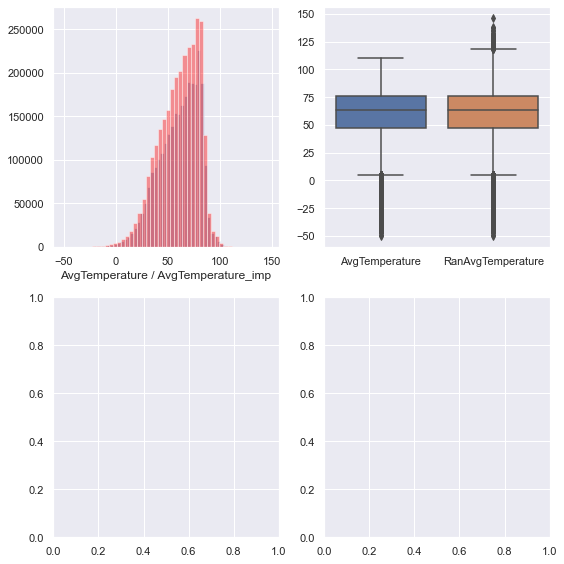

In [20]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["AvgTemperature"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
    axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')
    
    sns.boxplot(data = pd.concat([df[variable], random_data["Ran" + variable]], axis = 1),
                ax = axes[index, 1])
    
    plt.tight_layout()

We can observe from the plots above that we have introduced some degree of variability into the variables and retained the native distribution as well.

In [21]:
pd.concat([df[["AvgTemperature"]], random_data[["RanAvgTemperature"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
AvgTemperature,2826655.0,60.373884,19.097440,-50.0,47.4,63.3,75.9,110.000000
RanAvgTemperature,2906327.0,60.419461,19.095217,-50.0,47.4,63.2,75.9,146.684685


An issue of concern about is that, Regression Imputation might not serve as the best method when a variable is missing majority of it's data, as in case of insulin. In these cases we have to use more powerful approaches as Maximum Likelihood Imputation and Multple Imputaton

Regression Imputation assumes that the data is Missing At Random.

For a better Regression model, we might have to follow different Data Transformation methods depending on our data.

Do observe that we have included Outcome as one of our predictors eventhough it is caused by the other variables under scrutiny.

This notebook does not describe the best method for many cases, rather it justs the demonstrates Regression Imputation as one of the methods.